In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.utils import shuffle
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input

2022-01-19 21:41:33.390116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-19 21:41:33.390206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def f(x):
    return x**2-6*x+9

In [5]:
def data_generator(x, sigma_0, samples):
    return np.random.normal(f(x), sigma_0*x, samples)

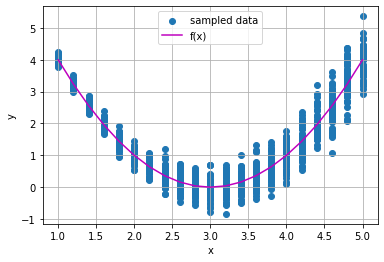

In [6]:
sigma_0 = 0.1
x_vals = np.arange(1, 5.2, 0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50

for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x, sigma_0, samples))

x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1, 5.1, 0.2)

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_arr, y_arr, label = 'sampled data')
plt.plot(x_vals, list(map(f, x_vals)), c = 'm', label = 'f(x)')
plt.legend(loc = 'upper center')
plt.show()

In [7]:
epochs = 500
batch_size = 50
learning_rate = 0.0003

model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(1,activation="linear"))
adamOptimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse',optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)

2022-01-19 21:41:48.044385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-19 21:41:48.044448: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-19 21:41:48.044497: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cmac-cameron-b2): /proc/driver/nvidia/version does not exist
2022-01-19 21:41:48.045300: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


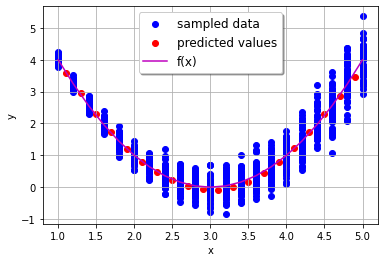

Final cost: 0.1211


In [8]:
y_pred = model.predict(x_test)

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_arr,y_arr,c='b',label='sampled data')
plt.scatter(x_test,y_pred,c='r',label='predicted values')
plt.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
plt.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()
print('Final cost: {0:.4f}'.format(history_cache.history['mse'][-1]))

In [9]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

In [10]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
InputLayer = Input(shape=(1,))
Layer_1 = Dense(12,activation="tanh")(InputLayer)
Layer_2 = Dense(12,activation="tanh")(Layer_1)
mu = Dense(1, activation="linear")(Layer_2)
sigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_2)
y_real = Input(shape=(1,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit([x_arr, y_arr], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))

Final cost: 0.1991


In [25]:
mu_pred, sigma_pred = model.predict(list((x_test,x_test))) # the model expects a list of arrays as it has 2 inputs
df = pd.concat([pd.DataFrame(data=mu_pred, columns = ['mu_pred']), pd.DataFrame(data=sigma_pred, columns = ['sigma_pred'])], axis = 1)

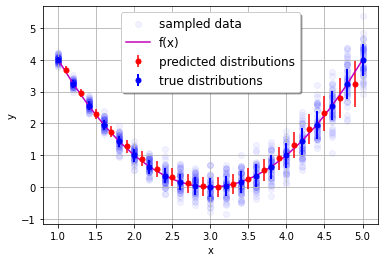

In [30]:
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x_test, df['mu_pred'], yerr=df['sigma_pred'], xerr=None,c='r',ls='None',marker='.',ms=10,label='predicted distributions')
plt.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
plt.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
plt.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
plt.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

In [ ]:
yerr = np.linspace(0.05, 0.2, 10)
yerr

In [ ]:
np.transpose(mu_pred)

In [ ]:
sigma_pred

In [ ]:
x_test

In [ ]:
np.transpose(np.absolute(sigma_pred))